In [1]:
# Brenda Woodard
# Data Mining Assignment 3
# In this assignment you will be mining the Kaggle "Bank Direct Marketing" data set
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve) 
from sklearn.metrics import *
from sklearn.naive_bayes import *
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import PCA 
from sklearn import cluster
from sklearn import metrics
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.neighbors import KNeighborsClassifier
from csv import reader
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.naive_bayes import MultinomialNB

In [2]:
# I provide the data set (and a smaller version) in better .csv format bank-full.csv & bank.csv
# The data set on Kaggle has many things that are not conducive to using the sklearn library: strings & negative values 

# Data Cleaning: I am supplying a file that reads the data set into a data frame & then transforms the data using 
# categorical mapping for the strings & normalization. Use this file as a starting point.

# This program assume the input.csv data set is the bank data set found in:
# assumes the data set is the bank direct marking data set found in: https://www.kaggle.com/psvishnu/bank-direct-marketing
# This program reads in 'input.csv' into a dataframe and then cleans it as follows:
# a) converts all string to categorical data; drops the column 'pdays'; normalizes the 'balance' column
pd.set_option('display.max_columns', None)
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.width = 0   # automatically ajust to window length

df = pd.read_csv('bank-full.csv')
# df = pd.read_csv('input.csv')
print("Original data set:")
print( df.head() )

# change all non-numeric into category data
df['job'] = df['job'].astype('category')
df['job'] = df['job'].cat.codes
df['marital'] = df['marital'].astype('category')
df['marital'] = df['marital'].cat.codes
df['education'] = df['education'].astype('category')
df['education'] = df['education'].cat.codes
df['default'] = df['default'].astype('category')
df['default'] = df['default'].cat.codes
df['contact'] = df['contact'].astype('category')
df['contact'] = df['contact'].cat.codes
df['month'] = df['month'].astype('category')
df['month'] = df['month'].cat.codes
df['poutcome'] = df['poutcome'].astype('category')
df['poutcome'] = df['poutcome'].cat.codes
df['housing'] = df['housing'].astype('category')
df['housing'] = df['housing'].cat.codes
df['loan'] = df['loan'].astype('category')
df['loan'] = df['loan'].cat.codes
df['y'] = df['y'].astype('category')
df['y'] = df['y'].cat.codes

df = df.drop('pdays',axis=1)

df['balance'] = (df['balance'] - df['balance'].min()) / ( df['balance'].max() - df['balance'].min() )
print("\n\nAfter converting to numeric, dropping pdays, and normalizing balance:")
print( df.head(10) )

# now create X and Y for machine learning algoirthms
Y = df['y']
df = df.drop('y',axis=1)
X = df

# partition into training and testing sets
x_train, x_test, y_train, y_test  = train_test_split( X, Y,  test_size=0.20, random_state=1)
print('len(x_train), len(y_train) = ' + str(len(x_train)) + ',' + str(len(y_train)) )
print('len(x_test), len(y_test) = ' + str(len(x_test)) + ',' + str(len(y_test)) )

Original data set:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


After converting to numeric, dropping pdays, and normalizing balance:
   age  job  marital

In [3]:
# Note - while numeric data is desired for classification/clustering, you need strings that look like market basket 
# data (sets of item names) for Association Rules. Numeric data can be grouped into names like: "lowValue, midValue, 
# mediumHighValue, highValue" etc. See the following code for a possible way of doing this (not necessarily the best):
# startForAssociationRules.py:

# It assume the data set is the bank direct marking data set found in: https://www.kaggle.com/psvishnu/bank-direct-marketing
# This program reads in 'input.csv' into a dataframe and then cleans it to prepare for association rules as follows:
# a) leaves things as strings, NOT numerical data
# b) converts numerical data into strings.  For example, balance converted to one of "very negative, negative, positive, 
#    very positive".  Similar for age
# c) changes yes/no for housing, default, and loan into:  housingYes/housingNo etc (so they are distinguishable from the 
#    other columns)

pd.set_option('display.max_columns', None)
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.width = 0   # automatically ajust to window length

df2 = pd.read_csv('bank-full.csv')
# df2 = pd.read_csv('input.csv')

print("Original data set:")
print(df2.head() )

df2 = df2.drop('pdays',axis=1)

for index, row in df.iterrows():
    if row['balance'] < 0:
        row['balance'] = 'inDebt'
    else:
        row['balance'] = 'notInDebt'

df2.loc[( df2['balance'] >= 10000), 'balanceSummary'] = 'veryPositive' 
df2.loc[( (df2['balance'] < 0) & (df2['balance'] >= -10000)), 'balanceSummary'] = 'negative' 
df2.loc[( (df2['balance'] < 10000) & (df2['balance'] >= 0)), 'balanceSummary'] = 'positive' 
df2.loc[df2['balance'] < -500, 'balanceSummary'] = 'veryNegative' 

df2.loc[( (df2['age'] < 25) & (df2['age'] >= 0)),  'ageBand'] = 'ageBand1' 
df2.loc[( (df2['age'] < 30) & (df2['age'] >= 25)), 'ageBand'] = 'ageBand2' 
df2.loc[( (df2['age'] < 40) & (df2['age'] >= 30)), 'ageBand'] = 'ageBand3' 
df2.loc[( (df2['age'] < 50) & (df2['age'] >= 40)), 'ageBand'] = 'ageBand4' 
df2.loc[( (df2['age'] < 120) & (df2['age'] >= 50)),'ageBand'] = 'ageBand5' 

df2.loc[ (df2['default'] == 'no'), 'defaultValue'] = 'defaultNo' 
df2.loc[ (df2['default'] == 'yes'), 'defaultValue'] = 'defaultYes' 
df2.loc[ (df2['housing'] == 'no'), 'housingVal'] = 'houseNo' 
df2.loc[ (df2['housing'] == 'yes'), 'housingVal'] = 'houseYes' 
df2.loc[ (df2['loan'] == 'no'), 'loanVal'] = 'loanNo' 
df2.loc[ (df2['loan'] == 'yes'), 'loanVal'] = 'loanYes' 

print("\n\nAfter converting to numeric, dropping pdays, and normalizing balance:")
print(df2.head(10))

# now drop stuff that is not a string
# Y = df['y']
# df = df.drop('y',axis=1)  # do not drop yes/no so you can make then subset rules into those that show "yes" versus "no"
df2 = df2.drop('age',axis = 1)
df2 = df2.drop('day',axis = 1)
df2 = df2.drop('duration',axis = 1)
df2 = df2.drop('balance',axis = 1)
df2 = df2.drop('campaign',axis = 1)
df2 = df2.drop('previous',axis = 1)
df2 = df2.drop('default',axis = 1)
df2 = df2.drop('housing',axis = 1)
df2 = df2.drop('loan',axis = 1)

print("\n\nFinal df:")
print(df2.head(10) )

df2.to_csv('outfile.csv',index = False )

Original data set:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


After converting to numeric, dropping pdays, and normalizing balance:
   age           job

In [14]:
# You are to apply the following techniques to mine this data set:
# Association Rules 
dat = []  
with open('bank-full.csv', 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        dat.append(row)
# dat

# use transaction encoder to transform into a 1-hot boolean encoded numpy arrayk
te = TransactionEncoder()
te_ary = te.fit(dat).transform(dat)
print("te_ary returned from TransactionEncoder.fit().transform():")
print(te_ary)

# convert into a data frame for convience & to pass into apriori
df2 = pd.DataFrame(te_ary,columns = te.columns_)
print("\n\nDataFrame version:")
print(df2.head(10))

# Call apriori to find frequent itemsets with min_support = 30%
freq_items = apriori(df2, min_support = 0.6, use_colnames = True)
print("\n\nfreq_items:")
print(freq_items.head())

# for index, row in freq_items.iterrows():
#     print(str(row[0]) + ' ' + str(row[1]) )

# # # NOTE: Do not assign back to freq_items because may remove rows need by association_rules() function below
# reducedFreqItems = freq_items[( ((freq_items['length'] == 2) &  (freq_items['support'] >= 0.40)) |
#     ((freq_items['length'] >= 3) &  (freq_items['support'] >= 0.30)) )]

# add a column to freq_items that contains the number of items in the itemset
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
print(type(freq_items))
print( freq_items.columns)
print(freq_items)

# print("\n\nReduced freq_items (length == 2 & support >= 40%) | (length >=3 & support >= 30%) ")
# print(reducedFreqItems)  

te_ary returned from TransactionEncoder.fit().transform():
[[False False False ... False  True False]
 [ True False False ...  True False  True]
 [ True False False ...  True False  True]
 ...
 [False False False ... False False  True]
 [ True False False ...  True False False]
 [False False False ... False False False]]


DataFrame version:
      -1    -10   -100  -1001  -1002  -1006  -1007   -101  -1011  -1013  \
0  False  False  False  False  False  False  False  False  False  False   
1   True  False  False  False  False  False  False  False  False  False   
2   True  False  False  False  False  False  False  False  False  False   
3   True  False  False  False  False  False  False  False  False  False   
4   True  False  False  False  False  False  False  False  False  False   
5   True  False  False  False  False  False  False  False  False  False   
6   True  False  False  False  False  False  False  False  False  False   
7   True  False  False  False  False  False  False  Fals



freq_items:
    support    itemsets
0  0.817482        (-1)
1  0.827280         (0)
2  0.647726  (cellular)
3  0.601920   (married)
4  0.999823        (no)
<class 'pandas.core.frame.DataFrame'>
Index(['support', 'itemsets', 'length'], dtype='object')


In [5]:
print("The rules:")
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.5)
print(type(rules))

# rename columns "antecedents support" to "antsup" and "consequents support" to "consup" so print nicer table
rules.columns = [ 'antecedents', 'consequents', 'antsup', 'consup', 'support', 'confidence', 'lift', 
                 'leverage', 'conviction']

print( rules[ ["antecedents","consequents","antsup","consup","support","confidence","lift"] ] )

print(rules.columns)
print(rules.head())

The rules:
<class 'pandas.core.frame.DataFrame'>
          antecedents        consequents    antsup    consup   support  \
0                 (0)               (-1)  0.827280  0.817482  0.817349   
1                (-1)                (0)  0.817482  0.827280  0.817349   
2                (no)               (-1)  0.999823  0.817482  0.817371   
3                (-1)               (no)  0.817482  0.999823  0.817371   
4           (unknown)               (-1)  0.826528  0.817482  0.817349   
5                (-1)          (unknown)  0.817482  0.826528  0.817349   
6                 (0)               (no)  0.827280  0.999823  0.827170   
7                (no)                (0)  0.999823  0.827280  0.827170   
8           (unknown)                (0)  0.826528  0.827280  0.817725   
9                 (0)          (unknown)  0.827280  0.826528  0.817725   
10         (cellular)               (no)  0.647726  0.999823  0.647594   
11               (no)         (cellular)  0.999823  0.647726  0

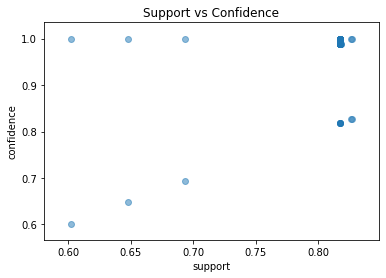

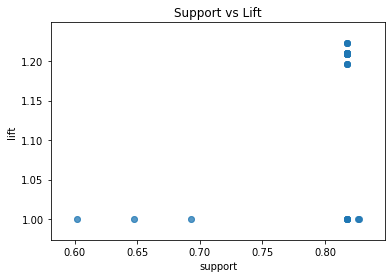

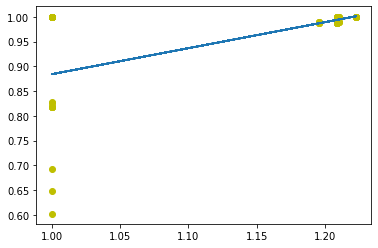

In [6]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))

In [7]:
# Use Principle Component Analysis to reduce the number of attributes (aka features) 
pca = PCA(n_components = 5)
pca = pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape 

# partition into training and testing sets
x_train, x_test, y_train, y_test  = train_test_split(X_pca, Y,  test_size=0.20, random_state=1)
print('len(x_train), len(y_train) = ' + str(len(x_train)) + ',' + str(len(y_train)) )
print('len(x_test), len(y_test) = ' + str(len(x_test)) + ',' + str(len(y_test)) )

len(x_train), len(y_train) = 36168,36168
len(x_test), len(y_test) = 9043,9043


In [8]:
# Decision Tree Classification
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train,y_train)
print(clf)
y_predicted = clf.predict(x_test)
print('\nconfusion_matrix from decision tree:')
print(confusion_matrix( y_test, y_predicted ) )
accuracy = accuracy_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
print('accuracy = ' + str(accuracy))
print('recall = ' + str(recall))
print('precision = ' + str(precision))
    
# Naive Bayes Classification
model = GaussianNB()
model.fit(x_train,y_train)
gausianNB_predicted = model.predict(x_test)
print('\nconfusion_matrix from Gaussian naive bayes:')
print(confusion_matrix( y_test, gausianNB_predicted ) )
accuracy = accuracy_score(y_test, gausianNB_predicted)
recall = recall_score(y_test, gausianNB_predicted )
precision = precision_score(y_test, gausianNB_predicted)
print('accuracy = ' + str(accuracy))
print('recall = ' + str(recall))
print('precision = ' + str(precision)) 

DecisionTreeClassifier()

confusion_matrix from decision tree:
[[7253  740]
 [ 706  344]]
accuracy = 0.8400973128386597
recall = 0.32761904761904764
precision = 0.3173431734317343

confusion_matrix from Gaussian naive bayes:
[[7729  264]
 [ 764  286]]
accuracy = 0.8863209112020347
recall = 0.2723809523809524
precision = 0.52


In [ ]:
# kmeans & dbscan clustering
x = np.array(X)
clustering = DBSCAN(eps = 3, min_samples = 2).fit(x)
print(clustering.labels_)
print(clustering)

# dendrogram using agglomerative clustering to see how many clusters will be optimal to specify in the kmeans clustering.
def plot_dendrogram(model, **kwargs): # Create linkage matrix and then plot the dendrogram
#     create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0 
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
                # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
                
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
# setting distance_threshold = 0 ensures you compute the full tree.
model = cluster.AgglomerativeClustering(distance_threshold = 0, n_clusters = None)
                                        
model = model.fit(X_pca)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p = 3)
plt.xlabel("Number of points in node (or index of point if no parentheesis).")
plt.xticks(rotation = 45)
plt.show() 

# Implement a kmeans clustering to find the clusters in the data
clu = cluster.KMeans(n_clusters = 2)
clu = clu.fit(X_pca)    
    
# Predict the clusters
y_pred = clu.predict(X_pca)
print(y_pred)
print(Y.head())   
    
# Visualize the clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_pred)

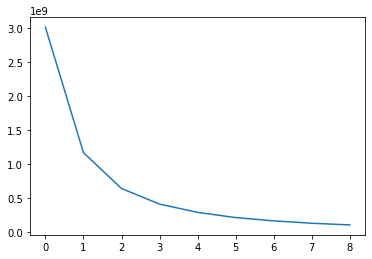

In [9]:
# Using a loop & a plot to tune the number of clusters. 
n_clusters = list(range(1, 10))
within_cluster_var = []
for i in n_clusters:
    clu = cluster.KMeans(n_clusters = i)
    clu = clu.fit(X_pca)
    within_cluster_var.append(clu.inertia_)
    
plt.plot(within_cluster_var)